### The University of Melbourne, School of Computing and Information Systems
# COMP90086 Computer Vision, 2022 Semester 2

## Assignment

# Import Libraries

In [9]:
import os
import numpy as np
import cv2
from matplotlib import pyplot as plt
from tqdm import tqdm

# Load sample image

In [10]:
cwd = os.getcwd()
data_set = cwd +"/Dataset"
img_left = cv2.imread(data_set + "/2018-07-09-16-11-56_2018-07-09-16-11-56-702-left.jpg", cv2.COLOR_BGR2RGB)
img_right = cv2.imread(data_set + "/2018-07-09-16-11-56_2018-07-09-16-11-56-702-right.jpg", cv2.COLOR_BGR2RGB)


# Show sample image

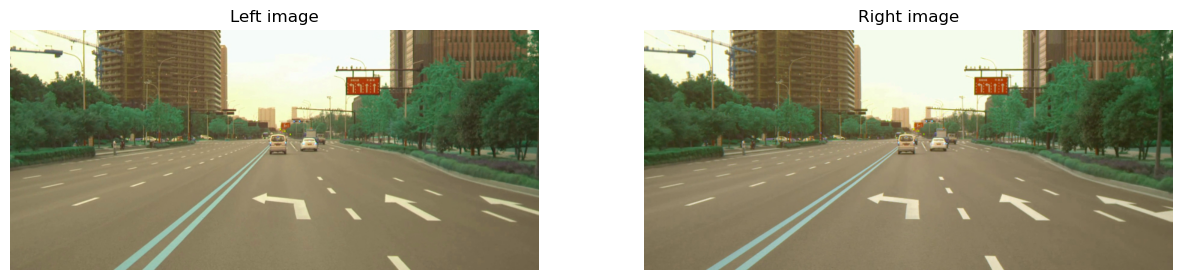

In [11]:
# Show images
plt.subplots(figsize=(15, 15)) 

plt.subplot(1,2,1)
plt.imshow(img_left, cmap='gray')  
plt.title("Left image")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img_right, cmap='gray')  
plt.title("Right image")
plt.axis('off')

plt.show() 

# Question 1
To calculate a disparity map for the left image using classical (non deep learning) methods

## Sum of Squared Differences (SSD)

In [4]:
def sum_of_abs_diff(pixel_vals_1, pixel_vals_2):
    """
    Args:
        pixel_vals_1 (numpy.ndarray): pixel block from left image
        pixel_vals_2 (numpy.ndarray): pixel block from right image

    Returns:
        float: Sum of absolute difference between individual pixels
    """
    if pixel_vals_1.shape != pixel_vals_2.shape:
        return -1

    return np.sum((pixel_vals_1 - pixel_vals_2)**2)

## Block comparision

In [5]:
BLOCK_SIZE = 7
SEARCH_BLOCK_SIZE = 56

def compare_blocks(y, x, block_left, right_array, block_size=5):
    """
    Compare left block of pixels with multiple blocks from the right
    image using SEARCH_BLOCK_SIZE to constrain the search in the right
    image.

    Args:
        y (int): row index of the left block
        x (int): column index of the left block
        block_left (numpy.ndarray): containing pixel values within the 
                    block selected from the left image
        right_array (numpy.ndarray]): containing pixel values for the 
                     entrire right image
        block_size (int, optional): Block of pixels width and height. 
                                    Defaults to 5.

    Returns:
        tuple: (y, x) row and column index of the best matching block 
                in the right image
    """
    # Get search range for the right image
    x_min = max(0, x - SEARCH_BLOCK_SIZE)
    x_max = min(right_array.shape[1], x + SEARCH_BLOCK_SIZE)
    #print(f'search bounding box: ({y, x_min}, ({y, x_max}))')
    first = True
    min_sad = None
    min_index = None
    for x in range(x_min, x_max):
        block_right = right_array[y: y+block_size,
                                  x: x+block_size]
        sad = sum_of_abs_diff(block_left, block_right)
        #print(f'sad: {sad}, {y, x}')
        if first:
            min_sad = sad
            min_index = (y, x)
            first = False
        else:
            if sad < min_sad:
                min_sad = sad
                min_index = (y, x)

    return min_index

# Disparity map calculation

In [6]:
h, w = img_left.shape[:2]
disparity_map = np.zeros((h, w), np.float32)
for y in tqdm(range(BLOCK_SIZE, h-BLOCK_SIZE)):
        for x in range(BLOCK_SIZE, w-BLOCK_SIZE):
            block_left = img_left[y:y + BLOCK_SIZE,
                                    x:x + BLOCK_SIZE]
            min_index = compare_blocks(y, x, block_left,
                                       img_right,
                                       block_size=BLOCK_SIZE)
            disparity_map[y, x] = abs(min_index[1] - x)

100%|█████████████████████████████████████████| 386/386 [03:12<00:00,  2.00it/s]


# Disparity visualization

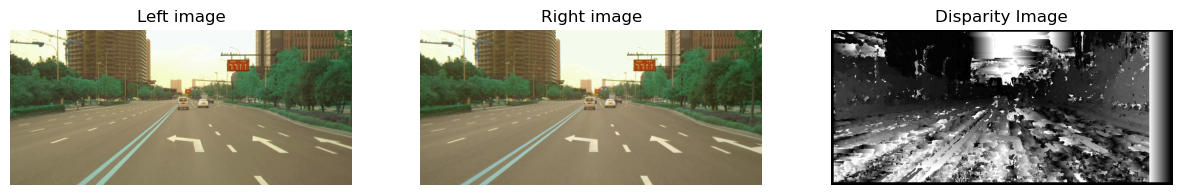

In [7]:
# Display the result
plt.subplots(figsize=(15, 15)) 

plt.subplot(1,3,1)
plt.imshow(img_left)  
plt.title('Left image')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(img_right)  
plt.title('Right image')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(disparity_map,'gray')
plt.title('Disparity Image')
plt.axis('off')

plt.show()

# Question 2

## Load and show ground truth image of disparity map

In [19]:
true_disparity_map = cv2.imread(data_set + "/2018-07-09-16-11-56_2018-07-09-16-11-56-702-disparity.png", cv2.COLOR_BGR2RGB)

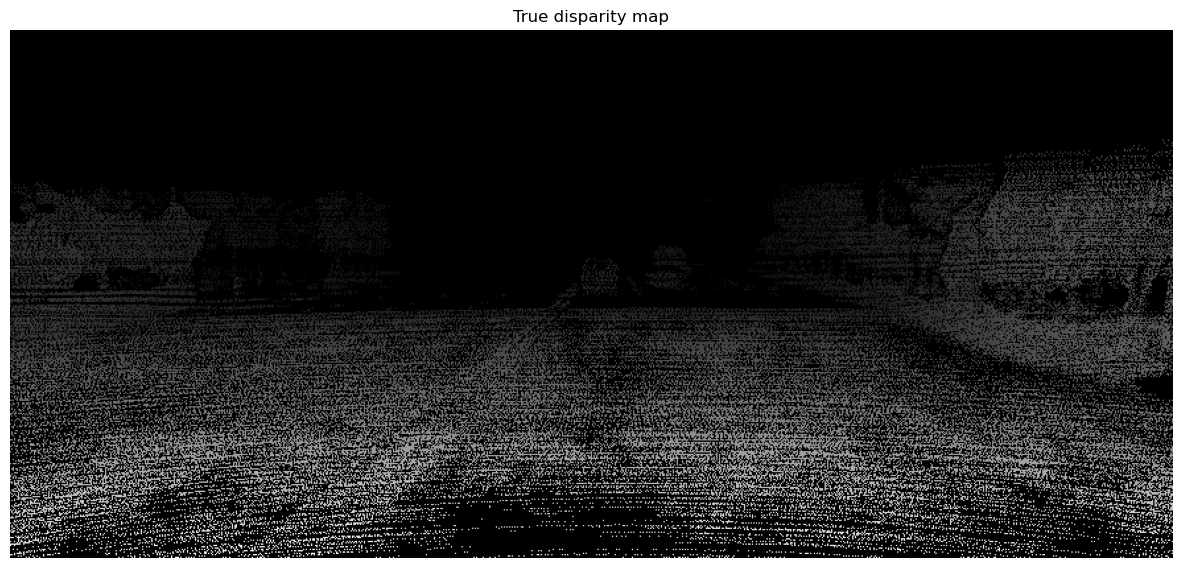

In [22]:
# Show images
plt.subplots(figsize=(15, 15)) 

plt.imshow(true_disparity_map, cmap='gray')  
plt.title("True disparity map")
plt.axis('off')

plt.show() 

## Roopt mean squared error

## Percenteage of pixels with erros

## Runtime